In [13]:
#importing packages
import numpy as np
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
import scipy.optimize as spop
import matplotlib.pyplot as plt

In [20]:
#specifying rolling window length
window = 22
#specifying maximum KPSS statistic (95% critical value)
KPSS_max = 0.463
#specifying the KPSS test (one-parameter unbiased or two-parameter)
unbiased = 1
#specifying whether to perform beta-loading or not
beta_loading = 0
#strategy parameters - trading fee, optimal entry (divergence), and stop-loss
fee = 0.0001
entry = 0.02
stop_loss = -0.05
#initially start in cash
signal = 0
current_return = 0
position0 = 0
position1 = 0
#specifying the sample
start = '2021-09-28'
end = '2023-06-19'
#specifying the pair
tickers = ['BHP', 'RIO']
#specifying the market index
market = 'ASX'
#initialising arrays
gross_returns = np.array([])
net_returns = np.array([])
market_returns = np.array([])
signals = np.array([])
KPSS_stats = np.array([])
raw_data = pd.DataFrame()

In [21]:
#downloading price data for stocks and the market index
for ticker in tickers:
    raw_data[ticker] = yf.download(ticker, start, end)['Close']
raw_data['market'] = yf.download(market, start, end)['Close']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [22]:
#defining the KPSS function (unbiased one-parameter forecast)
def KPSS(b):
            a = np.average(data[tickers[1]] - b*data[tickers[0]])
            resid = np.array(data[tickers[1]] - (a + b*data[tickers[0]]))
            cum_resid = np.cumsum(resid)
            st_error = (np.sum(resid**2)/(len(resid)-2))**(1/2)
            KPSS = np.sum(cum_resid**2)/(len(resid)**2*st_error**2)
            return KPSS
#defining the KPSS function (two-parameter)
def KPSS2(kpss_params):
            a = kpss_params[0]
            b = kpss_params[1]
            resid = np.array(data[tickers[1]] - (a + b*data[tickers[0]]))
            cum_resid = np.cumsum(resid)
            st_error = (np.sum(resid**2)/(len(resid)-2))**(1/2)
            KPSS = np.sum(cum_resid**2)/(len(resid)**2*st_error**2)
            return KPSS

In [23]:
#moving in a loop through the sample
for t in range(window, len(raw_data)-1):
    old_signal = signal
    old_position0 = position0
    old_position1 = position1
    #specifying the subsample
    data = raw_data[t-window:t]
    #stock 2 = a + b*stock 1
    #OLS parameters as starting values
    reg = sm.OLS(np.array(data[tickers[1]]), sm.add_constant(np.array(data[tickers[0]])))
    res = reg.fit()
    a0 = res.params[0]
    b0 = res.params[1]
    if unbiased == 1:
        #minimising the KPSS function (maximising the stationarity)
        res = spop.minimize(KPSS, b0, method='Nelder-Mead')
        KPSS_opt = res.fun
        #retrieving optimal parameters
        b_opt = float(res.x)
        a_opt = np.average(data[tickers[1]] - b_opt*data[tickers[0]]) 
    else:

        #minimising the KPSS function (maximising the stationarity)
        res = spop.minimize(KPSS2, [a0, b0], method='Nelder-Mead')
        #retrieving optimal parameters
        KPSS_opt = res.fun
        a_opt = res.x[0]
        b_opt = res.x[1]
    #simulate trading
    #first check whether stop-loss is violated
    if current_return < stop_loss:
        signal = 0
        print('stop-loss triggered')
    #if we are already in position, check whether the equilibrium is restored, continue in position if not
    elif np.sign(raw_data[tickers[1]][t] - (a_opt + b_opt*raw_data[tickers[0]][t])) == old_signal:
        singal = old_signal
    else:
        #only trade if the pair is cointegrated
        if KPSS_opt > KPSS_max:
            signal = 0
        #only trade if there are large enough profit opportunities (optimal entry)
        elif abs(raw_data[tickers[1]][t]/(a_opt + b_opt*raw_data[tickers[0]][t])-1) < entry:
            signal = 0
        else:
            signal = np.sign(raw_data[tickers[1]][t] - (a_opt + b_opt*raw_data[tickers[0]][t]))
    #calculate strategy returns with beta loading
    if beta_loading == 1:
        rets0 = np.array(raw_data[tickers[0]][t-window:t-1])/np.array(raw_data[tickers[0]][t-window+1:t]) - 1
        rets1 = np.array(raw_data[tickers[1]][t-window:t-1])/np.array(raw_data[tickers[1]][t-window+1:t]) - 1
        rets_mkt = np.array(raw_data['market'][t-window:t-1])/np.array(raw_data['market'][t-window+1:t]) - 1
        reg = sm.OLS(rets0, sm.add_constant(rets_mkt))
        res = reg.fit()
        beta0 = res.params[1]
        reg = sm.OLS(rets1, sm.add_constant(rets_mkt))
        res = reg.fit()
        beta1 = res.params[1]
        position0 = beta1*signal
        position1 = -beta0*signal
    #calculate strategy returns without beta loading
    else:
        position0 = signal
        position1 = -signal
    #calculating returns
    gross = position0*(raw_data[tickers[0]][t+1]/raw_data[tickers[0]][t] - 1) + position1*(raw_data[tickers[1]][t+1]/raw_data[tickers[1]][t] - 1)
    net = gross - fee*(abs(position0 - old_position0) + abs(position1 - old_position1))
    market = raw_data['market'][t+1]/raw_data['market'][t] - 1
    if signal == old_signal:
        current_return = (1+current_return)*(1+gross)-1
    else:
        current_return = gross
    #populating arrays
    KPSS_stats = np.append(KPSS_stats, KPSS_opt)
    signals = np.append(signals, signal)
    gross_returns = np.append(gross_returns, gross)
    net_returns = np.append(net_returns, net)
    market_returns = np.append(market_returns, market)

stop-loss triggered
stop-loss triggered
stop-loss triggered


In [24]:
#building the output dataframe
output = pd.DataFrame()
output['KPSS'] = KPSS_stats
output['signal'] = signals
output['gross'] = gross_returns
output['net'] = net_returns
output['market'] = market_returns
#visualising the results
# plt.plot(np.append(1,np.cumprod(1+gross_returns)))

# plt.plot(np.append(1,np.cumprod(1+market_returns)))

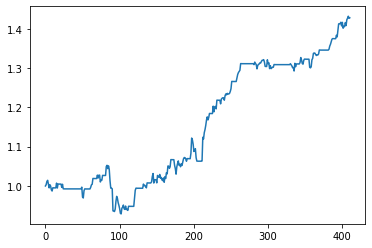

In [27]:
plt.plot(np.append(1,np.cumprod(1+net_returns)))

In [12]:
output['net']

0      0.003364
1      0.008097
2      0.002814
3     -0.008931
4     -0.010073
         ...   
348    0.002308
349   -0.000200
350    0.000000
351    0.000000
352    0.000000
Name: net, Length: 353, dtype: float64